In [18]:
from pandas import DataFrame
import torch.nn as nn


from MyModule import (
    load_data, 
    load_vocab, 
    train_model_with_validation, 
    test_model_comprehensive, 
    plot_training_curves,
    print_training_summary,
    save_training_results,
    BowDataset
)

train_data = load_data("train_indexed.txt", sep=",", is_indexed=True)
val_data = load_data("val_indexed.txt", sep=",", is_indexed=True)
test_data = load_data("test_indexed.txt", sep=",", is_indexed=True)

# 加载数据
train_dataset = BowDataset(train_data)
val_dataset = BowDataset(val_data)
test_dataset = BowDataset(test_data)

vocab = load_vocab("vocab.txt")

In [19]:
import numpy as np
import torch

def load_pretrained_embeddings(embedding_path, vocab, embedding_dim=200):
    """根据已有 vocab 构建嵌入矩阵"""
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))  # 随机初始化
    with open(embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            if word in vocab.token_to_idx:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

embedding_matrix = load_pretrained_embeddings("Word2Vec-100000-small.txt", vocab, embedding_dim=200)

In [20]:
from torch.utils.data import DataLoader
from MyModule import MLP, collate_fn_mlp

# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10


train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_pre_emb = MLP(len(vocab), embedding_dim, hidden_dim, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
mlp_pre_emb.to(device)

MLP(
  (embeddingbag): EmbeddingBag(34038, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:

# 训练过程
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_pre_emb.parameters(), lr=0.001)

mlp_history = train_model_with_validation(
    model=mlp_pre_emb,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)


Training Epoch 1: 100%|██████████| 7827/7827 [00:35<00:00, 221.79it/s]


Epoch 1/10
    Train Loss: 0.6591	Train Accuracy: 0.7228
    Valid Loss: 0.6110	Valid Accuracy: 0.7419
    Valid Precision: 0.7337	Valid Recall: 0.7419	Valid F1: 0.7249
    ✓ New best validation loss: 0.6110
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [00:31<00:00, 246.89it/s]


Epoch 2/10
    Train Loss: 0.5613	Train Accuracy: 0.7687
    Valid Loss: 0.6075	Valid Accuracy: 0.7501
    Valid Precision: 0.7415	Valid Recall: 0.7501	Valid F1: 0.7420
    ✓ New best validation loss: 0.6075
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [00:31<00:00, 251.18it/s]


Epoch 3/10
    Train Loss: 0.5133	Train Accuracy: 0.7896
    Valid Loss: 0.6169	Valid Accuracy: 0.7504
    Valid Precision: 0.7404	Valid Recall: 0.7504	Valid F1: 0.7383
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [00:31<00:00, 248.10it/s]


Epoch 4/10
    Train Loss: 0.4730	Train Accuracy: 0.8082
    Valid Loss: 0.6305	Valid Accuracy: 0.7512
    Valid Precision: 0.7428	Valid Recall: 0.7512	Valid F1: 0.7447
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [00:31<00:00, 251.39it/s]


Epoch 5/10
    Train Loss: 0.4380	Train Accuracy: 0.8241
    Valid Loss: 0.6734	Valid Accuracy: 0.7485
    Valid Precision: 0.7383	Valid Recall: 0.7485	Valid F1: 0.7395
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.6075


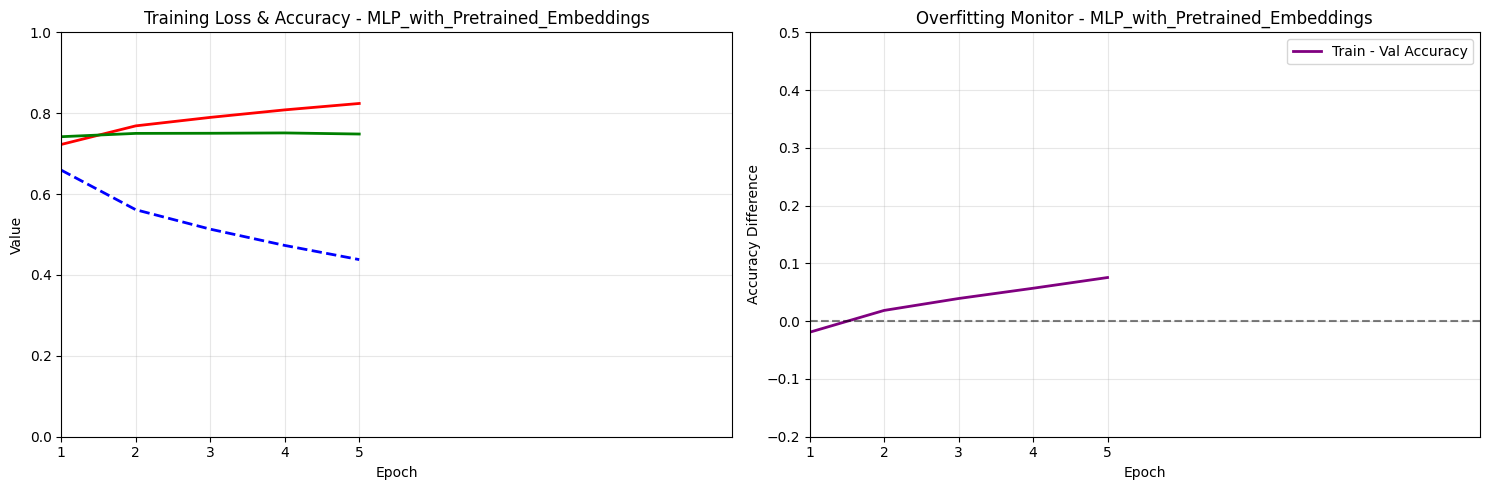


TRAINING SUMMARY
Model Name: MLP_with_Pretrained_Embeddings
Final Train Loss: 0.4380
Final Train Accuracy: 0.8241
Final Val Loss: 0.6734
Final Val Accuracy: 0.7485
Best Val Accuracy: 0.7512 (Epoch 4)
Final Overfitting Gap: 0.0756


In [5]:
# 绘制训练曲线
plot_training_curves("MLP_with_Pretrained_Embeddings", mlp_history)

# 打印训练摘要
print_training_summary("MLP_with_Pretrained_Embeddings", mlp_history)

Testing: 100%|██████████| 53687/53687 [00:54<00:00, 990.80it/s] 



TEST RESULTS
Model Name: MLP_with_pretrained_embeddings
Test Accuracy: 0.1862
Test Precision (weighted): 0.3243
Test Recall (weighted): 0.1862
Test F1 Score (weighted): 0.0662

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.3282    0.0023    0.0046     18614
     Neutral     0.1839    0.9828    0.3099      9924
    Positive     0.3769    0.0080    0.0157     25149

    accuracy                         0.1862     53687
   macro avg     0.2964    0.3310    0.1101     53687
weighted avg     0.3243    0.1862    0.0662     53687



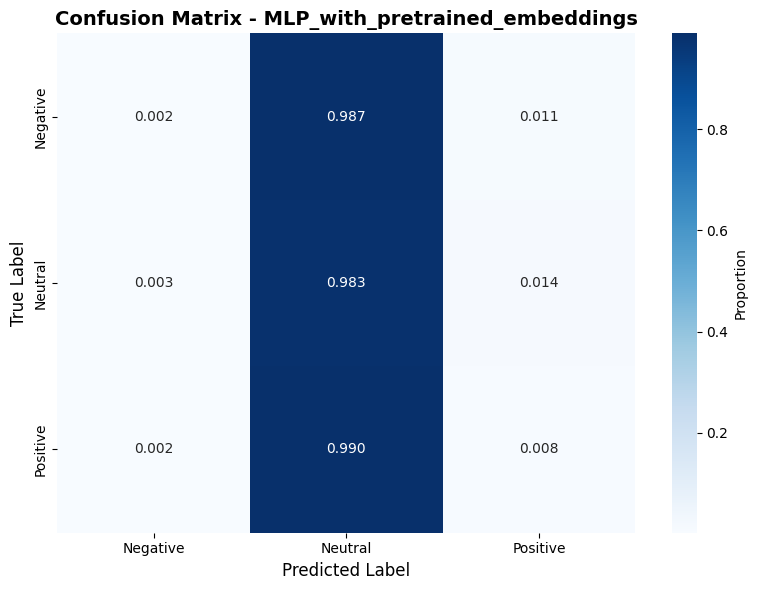


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.3282, Recall=0.0023, F1=0.0046, Support=18614
 Neutral: Precision=0.1839, Recall=0.9828, F1=0.3099, Support=9924
Positive: Precision=0.3769, Recall=0.0080, F1=0.0157, Support=25149


In [21]:
mlp_test_results = test_model_comprehensive(
    model=mlp_pre_emb,
    model_name="MLP_with_pretrained_embeddings",
    test_loader=test_data_loader_mlp,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [7]:
# 保存MLP训练结果
save_training_results(
    model=mlp_pre_emb,
    model_name="MLP with Pretrained Embeddings",
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=mlp_history,
    test_results=mlp_test_results,
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: MLP with Pretrained Embeddings (MLP)
  - 实际训练轮数: 5
  - 测试准确率: 0.7505
  - 测试F1分数: 0.7426
  - 记录时间: 2025-11-14 22:45:06
  - 总记录数: 6


{'model_class': 'MLP',
 'model_name': 'MLP with Pretrained Embeddings',
 'actual_epochs': 5,
 'device': 'cuda',
 'use_pretrained_embeddings': False,
 'training_history': {'train_losses': [0.6591401570972178,
   0.5613457322238703,
   0.513281463723812,
   0.4730444133578703,
   0.43799866916226504],
  'train_accuracies': [0.7227505749329245,
   0.7687132681742685,
   0.7896464162514373,
   0.8082478919126102,
   0.824086495464418],
  'val_losses': [0.6110375402794975,
   0.607478437152679,
   0.6168534587158492,
   0.6305274159710796,
   0.6734155899222332],
  'val_accuracies': [0.7419048328799791,
   0.7501024704698737,
   0.7504005663822335,
   0.7512389611357454,
   0.7485188359354622],
  'early_stopped': True,
  'best_val_loss': 0.607478437152679,
  'stopped_epoch': 5},
 'test_results': {'accuracy': 0.7505355113900944,
  'precision': 0.7414715046632325,
  'recall': 0.7505355113900944,
  'f1': 0.7426236767020183},
 'timestamp': '2025-11-14 22:45:06',
 'model_config': {'total_paramet

In [6]:
from MyModule import CNN, collate_fn_cnn

train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_pre_emb = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
cnn_pre_emb.to(device)

CNN(
  (embedding): Embedding(34038, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [7]:
# 训练过程
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_pre_emb.parameters(), lr=0.001)

cnn_history = train_model_with_validation(
    model=cnn_pre_emb,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7827/7827 [00:35<00:00, 220.26it/s]


Epoch 1/10
    Train Loss: 0.6250	Train Accuracy: 0.7361
    Valid Loss: 0.6200	Valid Accuracy: 0.7580
    Valid Precision: 0.7502	Valid Recall: 0.7580	Valid F1: 0.7509
    ✓ New best validation loss: 0.6200
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [00:34<00:00, 228.15it/s]


Epoch 2/10
    Train Loss: 0.5336	Train Accuracy: 0.7808
    Valid Loss: 0.5917	Valid Accuracy: 0.7568
    Valid Precision: 0.7510	Valid Recall: 0.7568	Valid F1: 0.7506
    ✓ New best validation loss: 0.5917
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [00:34<00:00, 228.30it/s]


Epoch 3/10
    Train Loss: 0.4852	Train Accuracy: 0.8042
    Valid Loss: 0.5827	Valid Accuracy: 0.7597
    Valid Precision: 0.7535	Valid Recall: 0.7597	Valid F1: 0.7556
    ✓ New best validation loss: 0.5827
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [00:34<00:00, 228.23it/s]


Epoch 4/10
    Train Loss: 0.4440	Train Accuracy: 0.8232
    Valid Loss: 0.5994	Valid Accuracy: 0.7507
    Valid Precision: 0.7509	Valid Recall: 0.7507	Valid F1: 0.7494
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [00:34<00:00, 228.45it/s]


Epoch 5/10
    Train Loss: 0.4083	Train Accuracy: 0.8379
    Valid Loss: 0.5990	Valid Accuracy: 0.7561
    Valid Precision: 0.7468	Valid Recall: 0.7561	Valid F1: 0.7488
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7827/7827 [00:34<00:00, 228.33it/s]


Epoch 6/10
    Train Loss: 0.3780	Train Accuracy: 0.8511
    Valid Loss: 0.6309	Valid Accuracy: 0.7479
    Valid Precision: 0.7417	Valid Recall: 0.7479	Valid F1: 0.7409
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5827


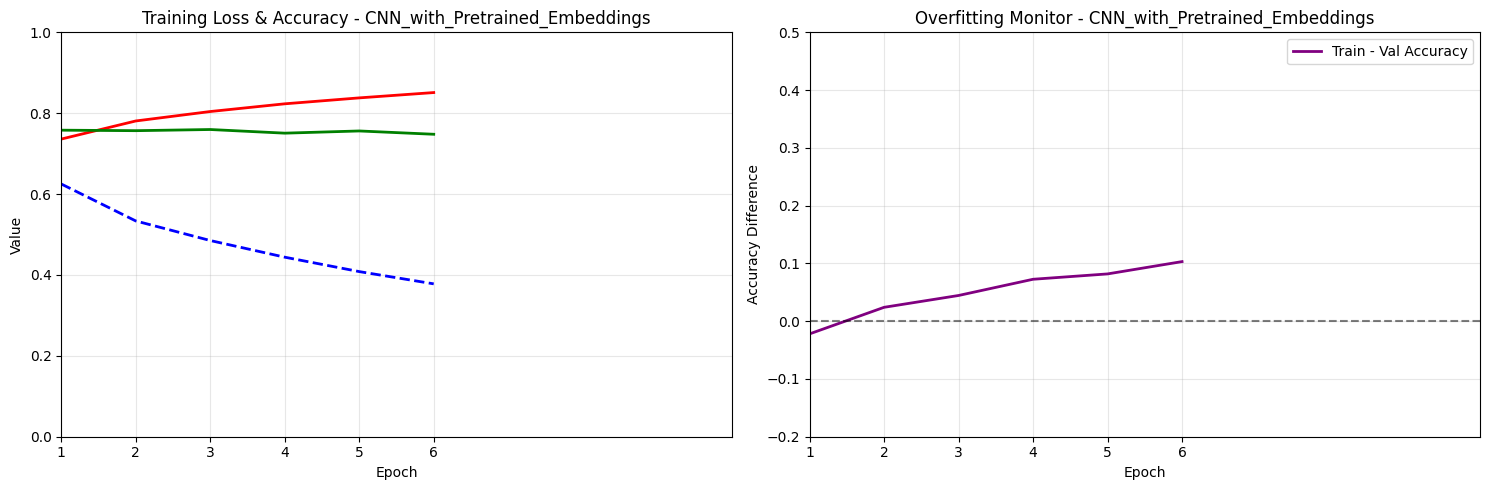


TRAINING SUMMARY
Model Name: CNN_with_Pretrained_Embeddings
Final Train Loss: 0.3780
Final Train Accuracy: 0.8511
Final Val Loss: 0.6309
Final Val Accuracy: 0.7479
Best Val Accuracy: 0.7597 (Epoch 3)
Final Overfitting Gap: 0.1031


In [8]:
# 绘制训练曲线
plot_training_curves("CNN_with_Pretrained_Embeddings", cnn_history)

# 打印训练摘要
print_training_summary("CNN_with_Pretrained_Embeddings", cnn_history)

Testing: 100%|██████████| 53687/53687 [00:55<00:00, 970.00it/s]



TEST RESULTS
Model Name: CNN with Pretrained Embeddings
Test Accuracy: 0.7555
Test Precision (weighted): 0.7479
Test Recall (weighted): 0.7555
Test F1 Score (weighted): 0.7504

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7895    0.7945    0.7919     18614
     Neutral     0.5629    0.4622    0.5076      9924
    Positive     0.7902    0.8423    0.8154     25149

    accuracy                         0.7555     53687
   macro avg     0.7142    0.6997    0.7050     53687
weighted avg     0.7479    0.7555    0.7504     53687



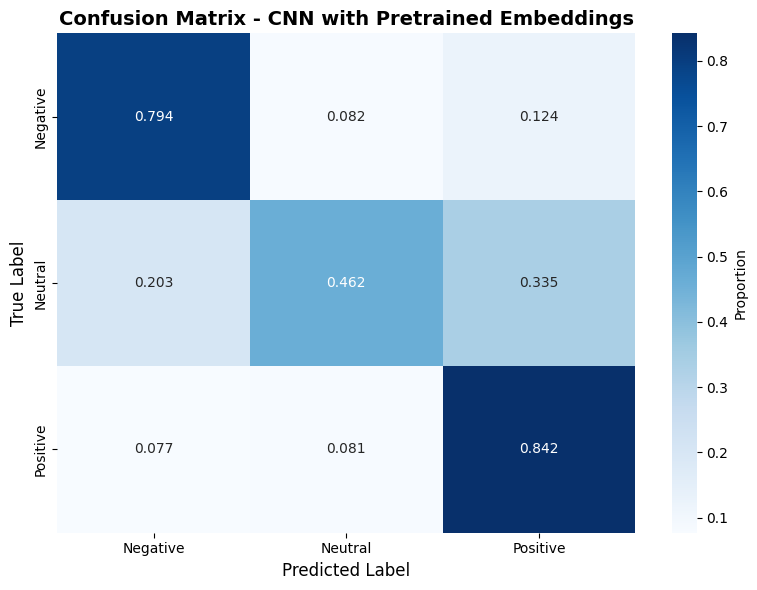


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7895, Recall=0.7945, F1=0.7919, Support=18614
 Neutral: Precision=0.5629, Recall=0.4622, F1=0.5076, Support=9924
Positive: Precision=0.7902, Recall=0.8423, F1=0.8154, Support=25149


In [9]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    test_loader=test_data_loader_cnn,
    device=device
)

In [10]:
from MyModule import LSTM, collate_fn_lstm

train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pre_emb = LSTM(len(vocab), embedding_dim, hidden_dim, num_class, 
                    embedding_matrix.clone().detach(), freeze=False)
lstm_pre_emb.to(device)

LSTM(
  (embeddings): Embedding(34038, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [11]:
# 训练过程
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_pre_emb.parameters(), lr=0.001)

lstm_history = train_model_with_validation(
    model=lstm_pre_emb,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
    )

Training Epoch 1: 100%|██████████| 7827/7827 [00:55<00:00, 142.06it/s]


Epoch 1/10
    Train Loss: 0.6141	Train Accuracy: 0.7412
    Valid Loss: 0.5573	Valid Accuracy: 0.7643
    Valid Precision: 0.7546	Valid Recall: 0.7643	Valid F1: 0.7562
    ✓ New best validation loss: 0.5573
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [00:53<00:00, 146.93it/s]


Epoch 2/10
    Train Loss: 0.4973	Train Accuracy: 0.7956
    Valid Loss: 0.5561	Valid Accuracy: 0.7701
    Valid Precision: 0.7605	Valid Recall: 0.7701	Valid F1: 0.7601
    ✓ New best validation loss: 0.5561
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [00:53<00:00, 147.10it/s]


Epoch 3/10
    Train Loss: 0.4206	Train Accuracy: 0.8288
    Valid Loss: 0.5631	Valid Accuracy: 0.7681
    Valid Precision: 0.7644	Valid Recall: 0.7681	Valid F1: 0.7660
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [00:53<00:00, 145.26it/s]


Epoch 4/10
    Train Loss: 0.3445	Train Accuracy: 0.8617
    Valid Loss: 0.6482	Valid Accuracy: 0.7606
    Valid Precision: 0.7597	Valid Recall: 0.7606	Valid F1: 0.7600
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [00:53<00:00, 146.86it/s]


Epoch 5/10
    Train Loss: 0.2764	Train Accuracy: 0.8901
    Valid Loss: 0.7520	Valid Accuracy: 0.7577
    Valid Precision: 0.7549	Valid Recall: 0.7577	Valid F1: 0.7562
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5561


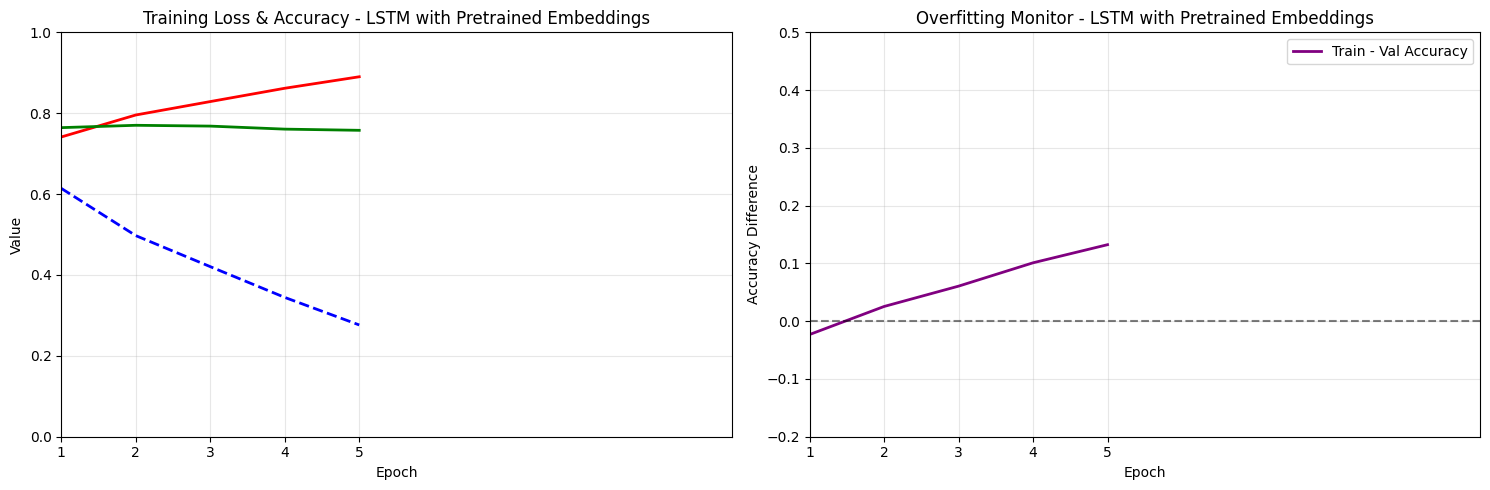


TRAINING SUMMARY
Model Name: LSTM with Pretrained Embeddings
Final Train Loss: 0.2764
Final Train Accuracy: 0.8901
Final Val Loss: 0.7520
Final Val Accuracy: 0.7577
Best Val Accuracy: 0.7701 (Epoch 2)
Final Overfitting Gap: 0.1324


In [12]:
# 绘制训练曲线
plot_training_curves("LSTM with Pretrained Embeddings", lstm_history)

# 打印训练摘要
print_training_summary("LSTM with Pretrained Embeddings", lstm_history)

Testing: 100%|██████████| 53687/53687 [01:36<00:00, 558.86it/s]



TEST RESULTS
Model Name: LSTM with Pretrained Embeddings
Test Accuracy: 0.7710
Test Precision (weighted): 0.7616
Test Recall (weighted): 0.7710
Test F1 Score (weighted): 0.7609

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8002    0.8155    0.8078     18614
     Neutral     0.6359    0.4190    0.5051      9924
    Positive     0.7826    0.8769    0.8271     25149

    accuracy                         0.7710     53687
   macro avg     0.7396    0.7038    0.7133     53687
weighted avg     0.7616    0.7710    0.7609     53687



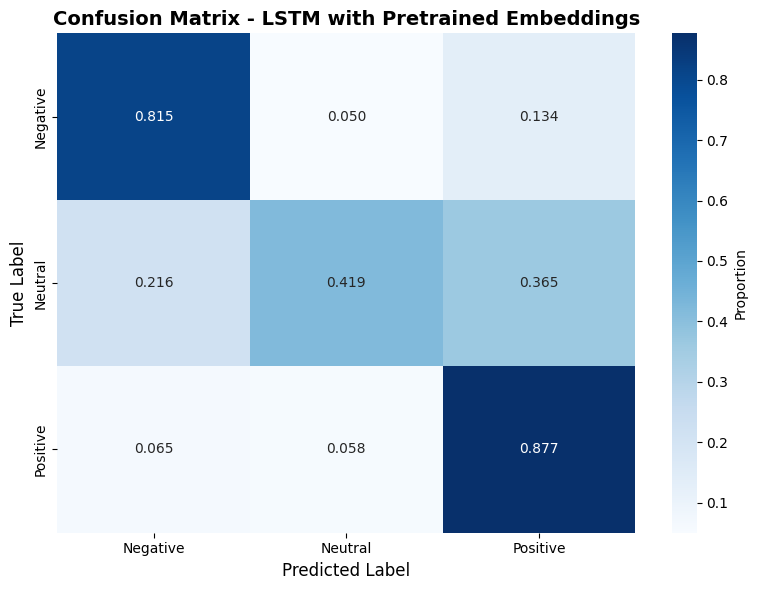


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8002, Recall=0.8155, F1=0.8078, Support=18614
 Neutral: Precision=0.6359, Recall=0.4190, F1=0.5051, Support=9924
Positive: Precision=0.7826, Recall=0.8769, F1=0.8271, Support=25149


In [13]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [14]:
from MyModule import Transformer, collate_fn_trans

train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_pre_emb = Transformer(len(vocab), embedding_dim, num_class, 
                                  pretrained_embedding_matrix=embedding_matrix.clone().detach(), 
                                  freeze=False)
transformer_pre_emb.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(34038, 200)
  (position_embedding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [15]:

# 训练过程
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_pre_emb.parameters(), lr=0.001)

transformer_history = train_model_with_validation(
    model=transformer_pre_emb,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7827/7827 [01:38<00:00, 79.50it/s]


Epoch 1/10
    Train Loss: 0.7414	Train Accuracy: 0.6881
    Valid Loss: 0.6905	Valid Accuracy: 0.7169
    Valid Precision: 0.7052	Valid Recall: 0.7169	Valid F1: 0.7070
    ✓ New best validation loss: 0.6905
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [00:59<00:00, 130.74it/s]


Epoch 2/10
    Train Loss: 0.7225	Train Accuracy: 0.6959
    Valid Loss: 0.7471	Valid Accuracy: 0.6696
    Valid Precision: 0.6914	Valid Recall: 0.6696	Valid F1: 0.6641
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [00:59<00:00, 131.25it/s]


Epoch 3/10
    Train Loss: 0.6703	Train Accuracy: 0.7262
    Valid Loss: 0.6753	Valid Accuracy: 0.7217
    Valid Precision: 0.7108	Valid Recall: 0.7217	Valid F1: 0.7125
    ✓ New best validation loss: 0.6753
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [01:01<00:00, 127.43it/s]


Epoch 4/10
    Train Loss: 0.6560	Train Accuracy: 0.7315
    Valid Loss: 0.6878	Valid Accuracy: 0.7178
    Valid Precision: 0.7060	Valid Recall: 0.7178	Valid F1: 0.7031
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [01:02<00:00, 125.82it/s]


Epoch 5/10
    Train Loss: 0.6590	Train Accuracy: 0.7338
    Valid Loss: 0.6885	Valid Accuracy: 0.7179
    Valid Precision: 0.7095	Valid Recall: 0.7179	Valid F1: 0.7102
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7827/7827 [00:57<00:00, 135.90it/s]


Epoch 6/10
    Train Loss: 0.6524	Train Accuracy: 0.7395
    Valid Loss: 0.7023	Valid Accuracy: 0.7154
    Valid Precision: 0.7055	Valid Recall: 0.7154	Valid F1: 0.7066
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.6753


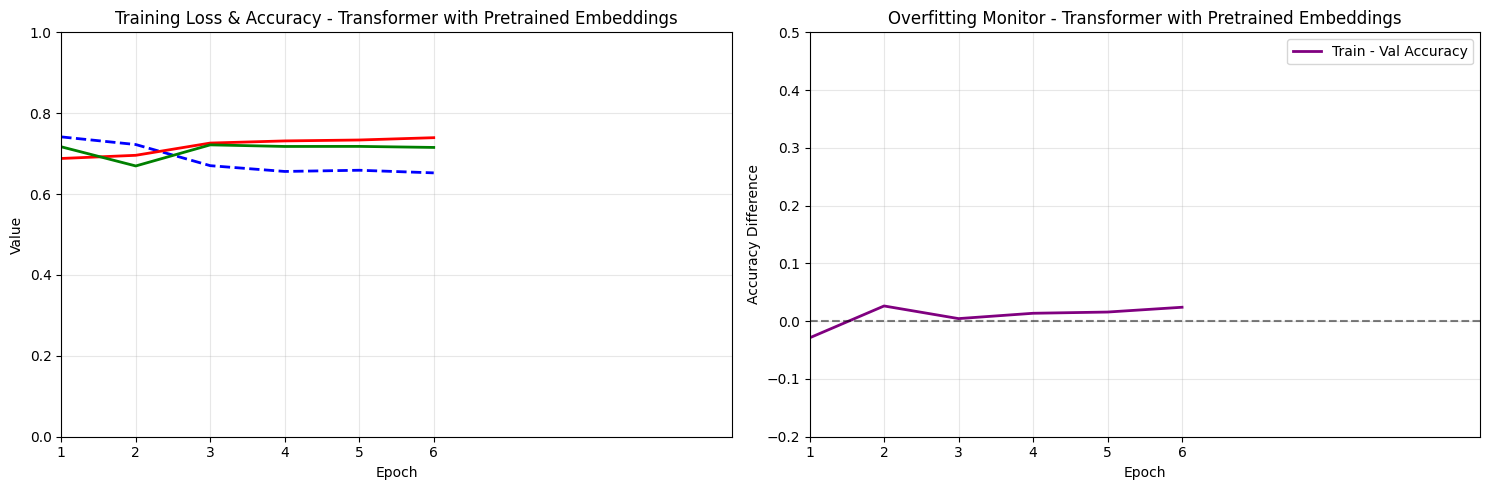


TRAINING SUMMARY
Model Name: Transformer with Pretrained Embeddings with Pretrained Embeddings
Final Train Loss: 0.6524
Final Train Accuracy: 0.7395
Final Val Loss: 0.7023
Final Val Accuracy: 0.7154
Best Val Accuracy: 0.7217 (Epoch 3)
Final Overfitting Gap: 0.0241


In [16]:
# 绘制训练曲线
plot_training_curves("Transformer with Pretrained Embeddings", transformer_history)

# 打印训练摘要
print_training_summary("Transformer with Pretrained Embeddings with Pretrained Embeddings", transformer_history)

Testing: 100%|██████████| 53687/53687 [01:52<00:00, 476.22it/s]



TEST RESULTS
Model Name: Transformer with Pretrained Embeddings
Test Accuracy: 0.7224
Test Precision (weighted): 0.7116
Test Recall (weighted): 0.7224
Test F1 Score (weighted): 0.7131

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7354    0.7751    0.7547     18614
     Neutral     0.5634    0.3836    0.4564      9924
    Positive     0.7525    0.8172    0.7835     25149

    accuracy                         0.7224     53687
   macro avg     0.6838    0.6586    0.6649     53687
weighted avg     0.7116    0.7224    0.7131     53687



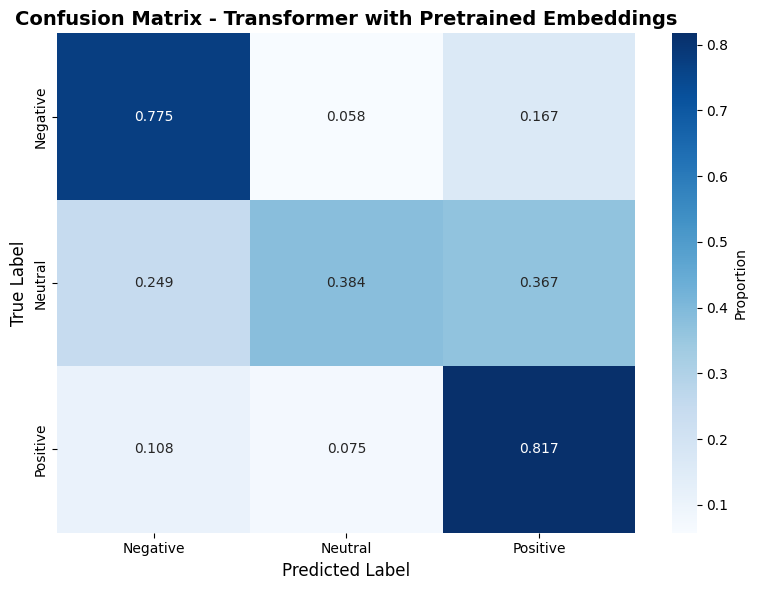


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7354, Recall=0.7751, F1=0.7547, Support=18614
 Neutral: Precision=0.5634, Recall=0.3836, F1=0.4564, Support=9924
Positive: Precision=0.7525, Recall=0.8172, F1=0.7835, Support=25149


In [17]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    test_loader=test_data_loader_trans,
    device=device
)